# Generate MetaData for Species Audio Files

This program is designed to create metadata for audio files in a specified directory. It accomplishes this in several steps:

CalcAudioDuration(length): This function calculates the audio duration in seconds, given the length of the audio in milliseconds. It converts milliseconds to seconds and returns the duration.

ComputeAudioDuration(filename): This function retrieves the duration of audio files. It first checks if the file exists and has a supported format (e.g., '.wav' or '.mp3'). If supported, it loads the audio file, calculates its length, and uses CalcAudioDuration to get the duration in seconds. Any errors during this process are caught and printed.

ExtractClassAndFile(path): This function extracts class names and filenames from subdirectories within a specified directory. It lists the subdirectories, iterates through them, and collects the class and filename information.

GetAudioDurations(path, classes, filenames): This function calculates the durations of audio files in the specified directory. It uses the ComputeAudioDuration function to process each audio file, collecting the durations into a list.

CreateMetaData(path): This function generates metadata for the audio files. It combines the class, filename, and duration information into a Pandas DataFrame and returns it.

WriteMetadata(path): This function writes the metadata DataFrame to a CSV file named 'species_metadata.csv' in the specified directory.

The script sets the 'path' variable to the directory containing the audio files and then calls 'WriteMetadata' to generate and save the metadata as a CSV file. This code ensures that the audio file durations are calculated accurately and included in the metadata for further analysis or use.

In [1]:
# Import the libraries
import os
from pydub import AudioSegment
import pandas as pd

In [2]:
def CalcAudioDuration(length):
    """
    Function to compute the duration. You could add more features like hours and minutes here, 
    but for now it would just be seconds.
    """
    seconds = length / 1000  # Convert milliseconds to seconds
    return seconds

def ComputeAudioDuration(filename):
    """
    This function will retrieve the duration from any file passed to it
    """
    try:
        ext = os.path.splitext(filename)[-1].lower()
        if ext not in ['.wav', '.mp3']:
            raise ValueError("Unsupported audio format")

        audio = AudioSegment.from_file(filename)
        length = len(audio)
        seconds = CalcAudioDuration(length)
        return seconds
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def ExtractClassAndFile(path):
    classes = []
    filenames = []
    for folder in os.listdir(path):
        folderpath = os.path.join(path, folder)
        if os.path.isdir(folderpath):
            for file in os.listdir(folderpath):
                if file.endswith(('.wav', '.mp3')):
                    classes.append(folder)
                    filenames.append(file)
    return classes, filenames

def GetAudioDurations(path, classes, filenames):
    seconds = []
    for cls, filename in zip(classes, filenames):
        filepath = os.path.join(path, cls, filename)
        second = ComputeAudioDuration(filepath)
        seconds.append(second)
    return seconds

def CreateMetaData(path):
    classes, filenames = ExtractClassAndFile(path)
    seconds = GetAudioDurations(path, classes, filenames)
    
    feature_colname = ['filename', 'seconds', 'class']
    df = pd.DataFrame({'Filename': filenames, 'Seconds': seconds, 'Class': classes})
    df['Seconds'] = df['Seconds'].fillna(0)
    return df

def WriteMetadata(path):
    df = CreateMetaData(path)
    df.to_csv(os.path.join(path, 'species_metadata.csv'), index=False)

path = "/Users/rahulprem/Uni/SIT782/Test2/"
WriteMetadata(path)

Finally, the script sets the 'path' variable to "./Data2/" and calls the 'WriteMetadata' function with this path, which generates metadata for audio files in the "./Data2/" directory and saves it in a CSV file named 'species_metadata.csv'.

In [3]:
pd.read_csv('/Users/rahulprem/Uni/SIT782/Test2/species_metadata.csv')

,Filename,Seconds,Class
0,region_34.000-36.000.mp3,2.029,Acanthiza chrysorrhoa
1,region_11.750-13.750.mp3,2.052,Acanthiza chrysorrhoa
2,region_15.200-16.050.mp3,0.877,Acanthiza chrysorrhoa
3,region_29.050-31.050.mp3,2.052,Acanthiza chrysorrhoa
4,region_10.150-12.150.mp3,2.029,Acanthiza chrysorrhoa
...,...,...,...
1392,region_687.050-689.050.mp3,2.029,Acanthagenys rufogularis
1393,region_22.000-23.300.mp3,1.333,Acanthagenys rufogularis
1394,region_462.000-464.000.mp3,2.029,Acanthagenys rufogularis
1395,region_196.800-198.800.mp3,2.052,Acanthagenys rufogularis


In [5]:
def ComputeClassDetails(meta_data_df):
    
    """This function that will calculate the total number of files in the folder/class
        and also their total duration in HH:MM:SS format"""
    
    result_df = meta_data_df.groupby('Class').agg(
        {'Filename': 'count', 'Seconds': 'sum'}
    ).reset_index()
    result_df.rename(columns={'Filename': 'No. of Samples'}, inplace=True)
    result_df['Seconds'] = result_df['Seconds'].round().astype(int)
    result_df['Total Duration'] = pd.to_timedelta(result_df['Seconds'], unit='s').apply(lambda x: str(x).split()[-1])
    result_df = result_df.drop(columns=['Seconds'])
    return result_df


meta_data_df = pd.read_csv('/Users/rahulprem/Uni/SIT782/Test2/species_metadata.csv')

ComputeClassDetails(meta_data_df)

,Class,No. of Samples,Total Duration
0,Acanthagenys rufogularis,718,00:21:56
1,Acanthiza apicalis,465,00:14:21
2,Acanthiza chrysorrhoa,214,00:06:42


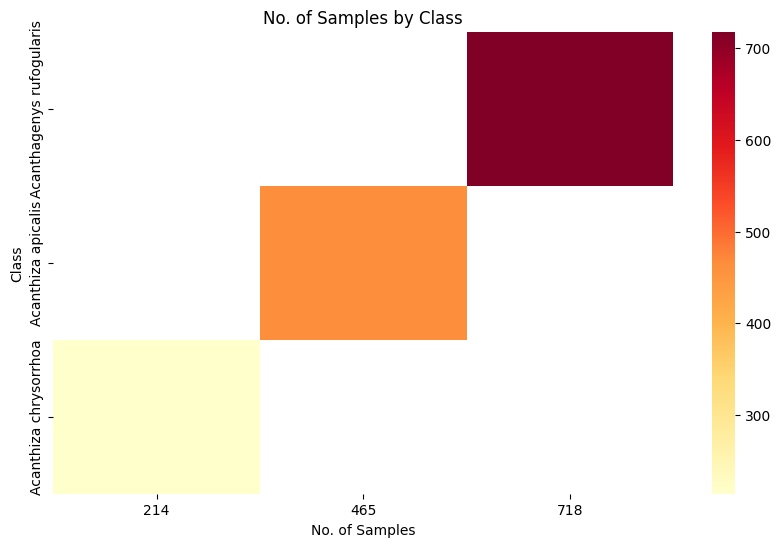

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

result_df = ComputeClassDetails(meta_data_df)
# Pivot the dataframe to create a heatmap for No. of Samples
heatmap_samples = result_df.pivot(index='Class', columns='No. of Samples', values='No. of Samples')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_samples, annot=False, cmap='YlOrRd')
plt.title('No. of Samples by Class')
plt.show()